In [1]:
from matplotlib.animation import FuncAnimation

from plot import *


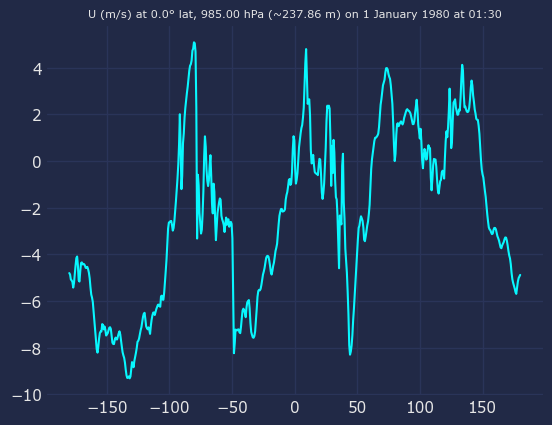

In [2]:
plot_variable_at_time_level_and_latitude_vs_longitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                                      time=0, level=71, latitude=180,
                                                      folder="compressed/wind")

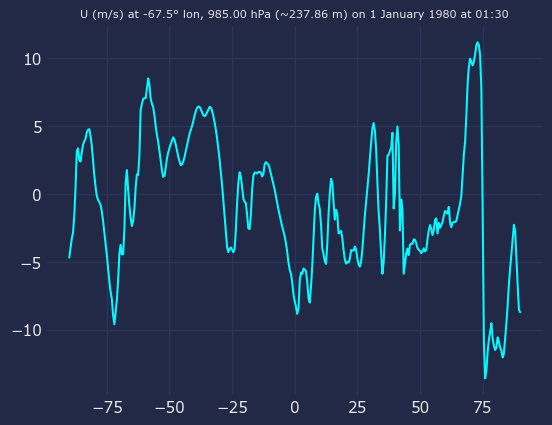

In [3]:
plot_variable_at_time_level_and_longitude_vs_latitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                                      time=0, level=71, longitude=180,
                                                      folder="compressed/wind")

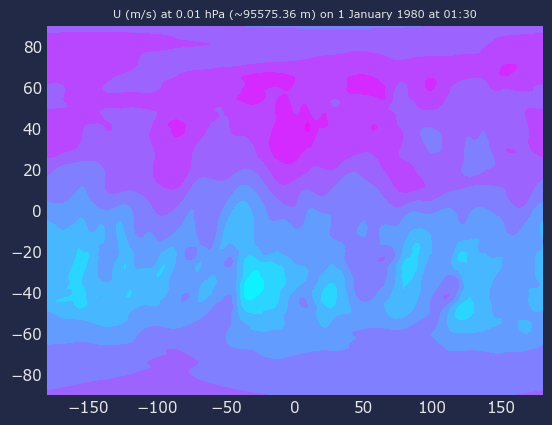

In [4]:
plot_contour_at_time_and_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U", time=0, level=0,
                               folder="compressed/wind")


In [ ]:
%matplotlib notebook
plot_interactive_contour_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U", time=0, title="East Wind (m/s)",
                                 folder="compressed/wind")


In [ ]:
%matplotlib notebook
plot_interactive_contour_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V", time=0, title="North Wind (m/s)",
                                 folder="compressed/wind")


In [ ]:
def _load_wind_data_at_time(filename, folder, time, contour_east, latitude_samples, longitude_samples):
    u_data = load_variable_at_time(filename, "U", time, folder=folder)
    v_data = load_variable_at_time(filename, "V", time, folder=folder)
    contour_data = (u_data if contour_east else v_data).copy()

    u_data = interpolate_variable_at_time(u_data, latitude_samples, longitude_samples)
    v_data = interpolate_variable_at_time(v_data, latitude_samples, longitude_samples)

    latitudes = np.linspace(0, u_data.shape[1], 361)
    longitudes = np.linspace(0, u_data.shape[2], 576)

    return u_data, v_data, contour_data, latitudes, longitudes


def plot_interactive_wind(filename: str, time: int,
                          folder: str = "compressed",
                          latitude_samples: int = 30,
                          longitude_samples: int | None = None,
                          contour_east: bool = True,
                          show_map: bool = True):
    u_data, v_data, contour_data, latitudes, longitudes = _load_wind_data_at_time(filename, folder, time, contour_east,
                                                                                  latitude_samples, longitude_samples)

    if show_map:
        coastlines, coastline_latitudes, coastline_longitudes = load_map(u_data.shape[1:])

    fig, ax, color_bar_ax, level_slider, resolution_slider = create_2_interactive_sliders_with_color_bar(
        "Wind Data (m/s)", 0, 71, 2, 32)

    def update(_):
        ax.clear()
        ax.set_yticks([])
        ax.set_xticks([])

        u_subdata = u_data[71 - level_slider.val]
        v_subdata = v_data[71 - level_slider.val]
        contour_subdata = contour_data[71 - level_slider.val]

        vmin, vmax = get_vmin_and_vmax(contour_subdata)

        contour = contourf(ax, resolution_slider.val, longitudes, latitudes, contour_subdata, vmin=vmin, vmax=vmax)
        fig.colorbar(contour, cax=color_bar_ax, fraction=0.05, pad=0.02)

        if show_map:
            draw_map(ax, coastlines, coastline_latitudes, coastline_longitudes)

        ax.barbs(u_subdata, v_subdata, barbcolor="#fff", flagcolor="#fff", length=3, linewidth=0.7)

    level_slider.on_changed(update)
    resolution_slider.on_changed(update)

    update(0)
    plt.show()


In [ ]:
%matplotlib notebook
plot_interactive_wind("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", time=0, folder="compressed/wind")

In [ ]:
def _plot_wind_at_level(ax, latitudes, longitudes, coastlines, coastline_latitudes, coastline_longitudes, u_data,
                        v_data, contour_data, level, show_map,
                        contour_levels: int = 32):
    ax.clear()
    ax.set_yticks([])
    ax.set_xticks([])

    if isinstance(level, int):
        u_subdata = u_data[71 - level]
        v_subdata = v_data[71 - level]
        contour_subdata = contour_data[71 - level]

        pressure = get_pressure_from_level(71 - level)

    elif isinstance(level, float):
        min_level = int(level)
        max_level = min_level + 1
        t = level % 1

        u_subdata = u_data[71 - max_level] * t
        u_subdata += u_data[71 - min_level] * (1 - t)
        v_subdata = v_data[71 - max_level] * t
        v_subdata += v_data[71 - min_level] * (1 - t)

        contour_subdata = contour_data[71 - max_level] * t
        contour_subdata += contour_data[71 - min_level] * (1 - t)

        pressure = get_pressure_from_level(71 - max_level) * t
        pressure += get_pressure_from_level(71 - min_level) * (1 - t)

    else:
        raise ValueError("level must be a number")

    contourf(ax, contour_levels, longitudes, latitudes, contour_subdata)

    if show_map:
        draw_map(ax, coastlines, coastline_latitudes, coastline_longitudes)

    ax.barbs(u_subdata, v_subdata, barbcolor="#fff", flagcolor="#fff", length=4, linewidth=0.6)
    ax.set_title(
        f"Wind at 1:30 AM on 1 January, 1980 at {pressure:.2f} hPa (~{height_from_pressure(100 * pressure):.2f} m)",
        color="#fff")


def plot_wind_at_level(filename: str, time: int, level: int,
                       folder: str = "compressed",
                       latitude_samples: int = 40,
                       longitude_samples: int | None = None,
                       contour_east: bool = True,
                       show_map: bool = True,
                       **kwargs):
    u_data, v_data, contour_data, latitudes, longitudes = _load_wind_data_at_time(filename, folder, time, contour_east,
                                                                                  latitude_samples, longitude_samples)

    px = 1 / plt.rcParams["figure.dpi"]
    fig, ax = plt.subplots(num="Wind Data",
                           figsize=(1728 * px, 1080 * px), facecolor=(0.1, 0.1, 0.1),
                           gridspec_kw={"left": 0, "right": 1, "bottom": 0, "top": 0.97, "hspace": 0, "wspace": 0})
    if show_map:
        coastlines, coastline_latitudes, coastline_longitudes = load_map(u_data.shape[1:])
    else:
        coastlines, coastline_latitudes, coastline_longitudes = None, None, None

    _plot_wind_at_level(ax, latitudes, longitudes, coastlines, coastline_latitudes, coastline_longitudes, u_data,
                        v_data, contour_data, level, show_map, **kwargs)
    plt.show()


In [ ]:
%matplotlib notebook
plot_wind_at_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", time=0, level=0, folder="compressed/wind")


In [ ]:
def animate_wind_vs_level(filename: str, time: int,
                          folder: str = "compressed",
                          output_dir: str = "assets/graphs",
                          file_format: str = "mp4",
                          fps: int = 10,
                          latitude_samples: int = 40,
                          longitude_samples: int | None = None,
                          contour_east: bool = True,
                          show_map: bool = True,
                          interpolation_levels: int = 4,
                          **kwargs):
    u_data, v_data, contour_data, latitudes, longitudes = _load_wind_data_at_time(filename, folder, time, contour_east,
                                                                                  latitude_samples, longitude_samples)

    if show_map:
        coastlines, coastline_latitudes, coastline_longitudes = load_map(u_data.shape[1:])

    px = 1 / plt.rcParams["figure.dpi"]
    plt.clf()
    fig, ax = plt.subplots(num="Wind Data",
                           figsize=(1728 * px, 1080 * px), facecolor=(0.1, 0.1, 0.1),
                           gridspec_kw={"left": 0, "right": 1, "bottom": 0, "top": 0.97, "hspace": 0, "wspace": 0})

    def animate(i):
        print(f"Frame {i}")

        i /= interpolation_levels
        if i > 71:
            i = 142 - i
        _plot_wind_at_level(ax, latitudes, longitudes, coastlines, coastline_latitudes, coastline_longitudes, u_data,
                            v_data, contour_data, i, show_map, **kwargs)

    frames = 71 * interpolation_levels
    if file_format == "gif":
        frames *= 2

    anim = FuncAnimation(fig, animate, frames=frames, interval=1, blit=True)
    output_file = f"{'east' if contour_east else 'north'}-wind-{filename.split('.')[-2]}-{1 + time * 3:0>2}:30"
    anim.save(f"{output_dir}/{output_file}-{interpolation_levels}.{file_format}", fps=fps)


In [ ]:
animate_wind_vs_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", time=0, folder="compressed/wind", contour_east=False)
